In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('bdi').hide();
 } else {
 $('div.input').show();
 $('bdi').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# IBM ML 02 - Project - Model for predicting Diabetes

## Objective:

This study focuses on prediction, the goal is predict diabetes progression in patients. More in particular is to predict, based on features like sex, body mass, etc, what would be the progression of the disease in the next year.


## The Dataset:

As a datates I used the available sklearn diabates dataset. This contains the following:

- Number of Instances: 442
- Number of Attributes: First 10 columns are numeric predictive values
- Target: Column 11 is a quantitative measure of disease progression one year after baseline

**Attribute Information**
- age     age in years
- sex
- bmi     body mass index
- bp      average blood pressure
- s1      tc, T-Cells (a type of white blood cells)
- s2      ldl, low-density lipoproteins
- s3      hdl, high-density lipoproteins
- s4      tch, thyroid stimulating hormone
- s5      ltg, lamotrigine
- s6      glu, blood sugar level

**Data types:** all values are numeric.

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
diabetes_data = load_diabetes()

In [5]:
x = pd.DataFrame(diabetes_data.data, columns=diabetes_data.feature_names)

## Data Exploration and Feature Engineering

The data presents two variables S1 and S2 that are fully correlated, at this point of the study I decided to keep them in both. Two variables S3 and S4 present skew above 0.7 and are transformed with **log1p**. All variables are also standardized scaled.



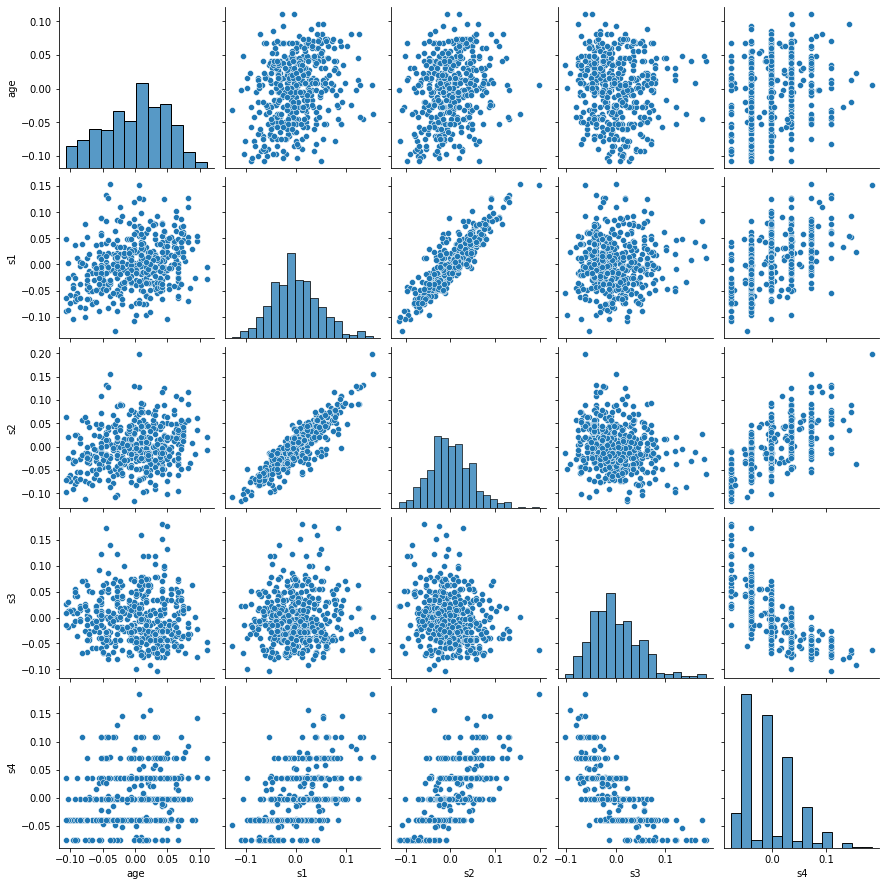

In [6]:
sns.pairplot(data=x[["age","s1","s2","s3","s4"]])

In [7]:
x["s4"] = np.log1p(x["s4"])

In [8]:
var_to_log = list(x.skew()[x.skew() > 0.7].index)

In [9]:
x[var_to_log] = np.log1p(x[var_to_log])

In [10]:
y = diabetes_data.target

### Correlation with target

According to the following scatter plots between target and each feature, we can expect that S3 and S5 must be amongst the most important features.

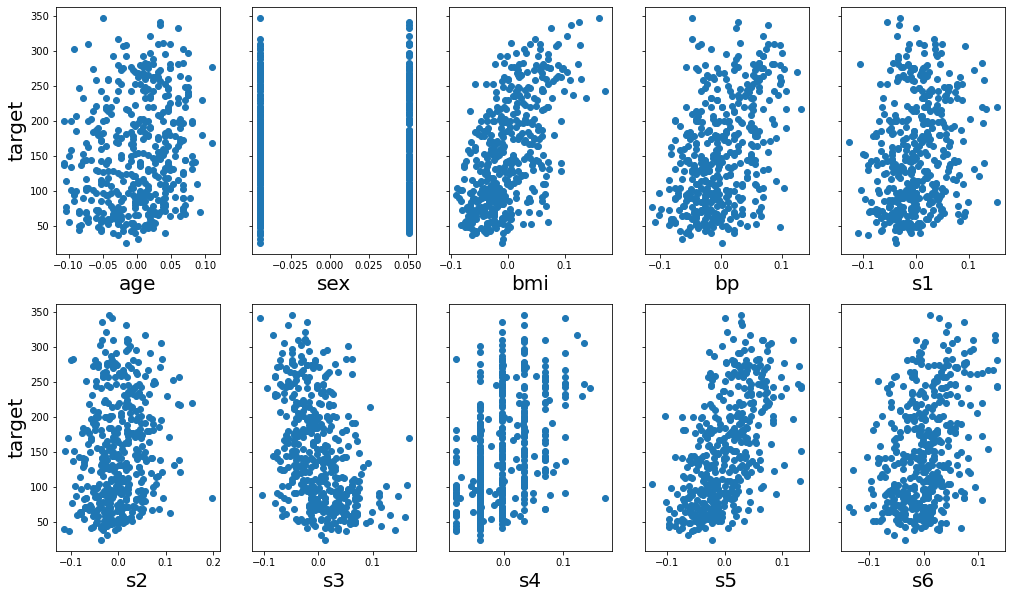

In [11]:
fig, ax = plt.subplots(2,5,figsize=(17,10), sharey=True)

ax[0,0].set_ylabel("target",fontsize=20)
ax[1,0].set_ylabel("target",fontsize=20)
ax_list = ax.reshape((10,)).tolist()

for col,_axis in zip(x.columns,ax_list):
    _axis.scatter(x[col],y)
    _axis.set_xlabel(col, fontsize=20)


## Linear regression models

Here I use 3 models to fit the data:

- A simple linear regression
- A linear regression of a Polinomial transform of the data, I only use a polinomial of third grade
- A Lasso regularizzation of the polinomial 3rd model

For each of the models I apply cross-validation splitting the dataset in 3 sub-sets, consistently for all models. I then compute the score for each model using the root square of the **mean-square-error as a metric**.

#### Hyperparameters

The only model here that have hyperparameters that I consider is Lasso. I use the cross-validation procedure to determine the best $\alpha$ value among a predefined set of values:



In [12]:
from sklearn.linear_model import LinearRegression, RidgeCV,LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_predict

In [13]:
# linear
lr = LinearRegression()
lr_prediction = cross_val_predict(lr, x,y, cv=3)
score_lr = np.sqrt(mean_squared_error(y, lr_prediction))

In [14]:
#pol 3
pol = PolynomialFeatures(degree=3, include_bias=False,)
lr2 = LinearRegression()
pol_est = Pipeline([("pol",pol),("reg",lr2)])
pol_prediction = cross_val_predict(pol_est, x,y, cv=3)
score_pol = np.sqrt(mean_squared_error(y, pol_prediction))

In [36]:
# Regularizzation 
pol2 = PolynomialFeatures(degree=3, include_bias=False)
x_pol = pol2.fit_transform(x)
alphas = np.geomspace(1E-5,10,6)
est_lasso = LassoCV(alphas=alphas, max_iter=1E5,cv=3)
t = est_lasso.fit(x_pol,y)

In [42]:
lasso_prediction = est_lasso.predict(x_pol)
score_lasso = np.sqrt(mean_squared_error(y, lasso_prediction))
print("Alpha values for Lasso: ")
for a in est_lasso.alphas:
    print("{:.2E}".format(a))

Alpha values for Lasso: 
1.00E-05
1.58E-04
2.51E-03
3.98E-02
6.31E-01
1.00E+01


## Results

Below a set of figure representing the Model-prediction VS the truth for the target parameter, the disease growth after one year. One can see the following:

- The prediction for the linear model are already very good.
- Adding polinomial features alone, with no regularization, leads to clear overfitting.
- Adding a Lasso regularization over the polinomial improves quite a lot the situation, but still compatible with just linear regression.



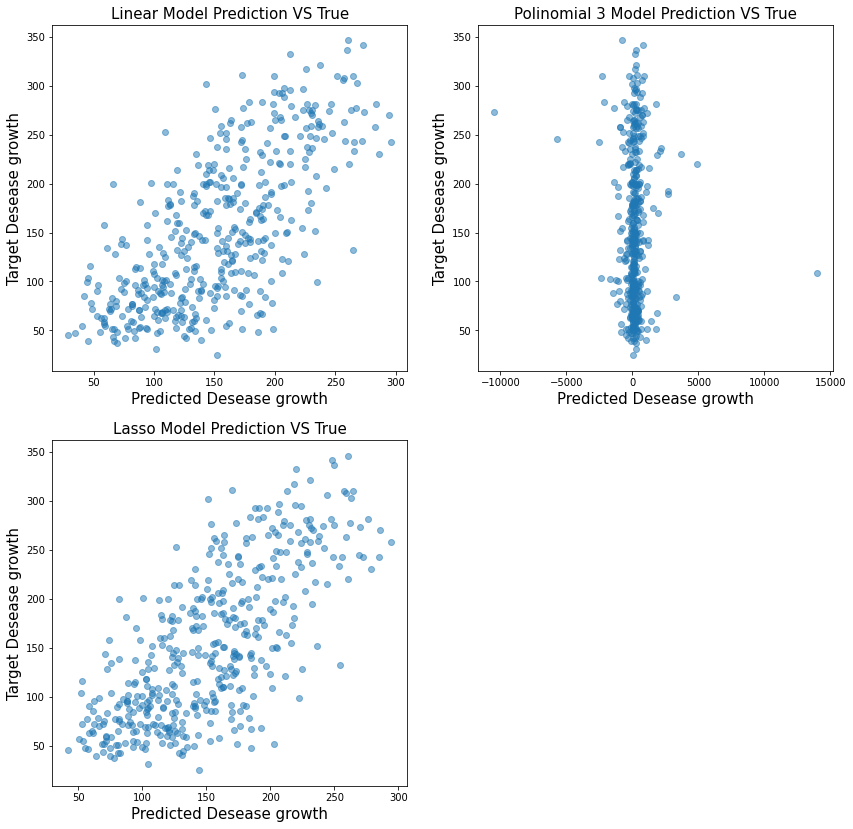

In [17]:
fig, ax = plt.subplots(2,2,figsize=(14,14))
ax = ax.reshape((4,))

ax[0].set_title("Linear Model Prediction VS True", fontsize=15)
ax[0].set_xlabel("Predicted Desease growth", fontsize=15)
ax[0].set_ylabel("Target Desease growth", fontsize=15)
ax[0].scatter(lr_prediction,y, alpha=0.5)

ax[1].scatter(pol_prediction,y, alpha=0.5)
ax[1].set_title("Polinomial 3 Model Prediction VS True", fontsize=15)
ax[1].set_xlabel("Predicted Desease growth", fontsize=15)
ax[1].set_ylabel("Target Desease growth", fontsize=15)

ax[2].scatter(lasso_prediction,y, alpha=0.5)
ax[2].set_title("Lasso Model Prediction VS True", fontsize=15)
ax[2].set_xlabel("Predicted Desease growth", fontsize=15)
ax[2].set_ylabel("Target Desease growth", fontsize=15)

ax[3].axis("off")
plt.show()

In [18]:
scores = pd.DataFrame({"Simple Linear":score_lr,"Polinomial 3":score_pol, "Lasso Regularized":score_lasso},index=["score"])

### Scores
One can see below the scores for the simple linear model, the simple polinomial of 3r degree, and the polinomial regularized with Lasso. The polinomial has the worst score, it is overfitting. The lasso regularized has the best score (sqrt of mean-square-error), however it is very close to the simple  linear model.

In [19]:
scores.head()

,Simple Linear,Polinomial 3,Lasso Regularized
score,55.030832,1093.716247,53.689837


### Feature Elimination

If one looks at the result for the best alpha value for Lasso, one realizes that a lot of the parameter are totally unnecessary. In fact the polinomial of 3r degree model has **285** parameters, the linear model has **10** parameters, all is reduced with best Lasso model to **7** non-zero parameters. Which means, as previously stated that there are parameters that are already either fully correlated or that have very little predictive power.

### Reccomendations

Based on what observed I reccomend to use directly a linear model, as is much faster to run than the Lasso and gives qualitatively very similar results.

In [20]:
#print(
#    "Number of feature in simple linear are {}, which are reduced in Lasso to {} "
#    .format(x.shape[1],np.count_nonzero(est_lasso.coef_))
#)

## Key Findings

Below is the sorted list of paramter coefficient values for the different, not-null, features in the best lasso model. It shows that the most predictive parameters (since all the parameter were scaled) are **bmi** and **S5**, which are respectively the **body mass index** and the **lamotrigine** blood content, while **sex** is one of the medium influential parameters.

In [35]:
names = pol2.get_feature_names(input_features=x.columns)
coeff = (est_lasso.coef_ != 0)
coef_ser = pd.Series(est_lasso.coef_, index=names)
coef_ser[coef_ser != 0].sort_values()

s3    -231.468358
sex   -203.400617
s1    -107.953647
s6      56.380932
bp     299.891665
s5     515.352788
bmi    522.602476
dtype: float64

## Next steps

This is a very simple analysis, there is one problem tough, with the given data one can only predict the growth of the deseas after one year.  Because of this:

- It would be nice to have data also for the following years in order to have a predictive model versus time. 
- Also it would be beneficial to have data also of people that do not have diabetes, so that one could make a predictive model with probability of having that deseas given the feature.
- A possible follow up study could be for example, to estimate which sex (f/m) is more prone to get diabetes.